In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow
import glob
import pickle
import pandas as pd


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive


[Errno 2] No such file or directory: 'drive'
/content/drive/My Drive/data


In [ ]:
cd My Drive

[Errno 2] No such file or directory: 'My Drive'
/content/drive/My Drive/data


In [ ]:
cd data

[Errno 2] No such file or directory: 'data'
/content/drive/My Drive/data


In [ ]:
x_normal = np.load('x_normal.npy')

x_viral = np.load('x_viral.npy')

x_bacterial = np.load('x_bacterial.npy')

x_covid = np.load('x_covid.npy')


In [ ]:
y_normal = []
y_viral = []
y_bacterial = []
y_covid = []

In [ ]:
print(x_normal.shape)
print(x_viral.shape)
print(x_bacterial.shape)
print(x_covid.shape)

(1583, 256, 256, 3)
(1504, 256, 256, 3)
(2786, 256, 256, 3)
(301, 256, 256, 3)


In [ ]:
import random
x_train=[]
y_train=[]
x_test = []
y_test = []

In [ ]:
nums = random.sample(range(0, 1504), 219)
for i in nums:
  x_train.append(x_viral[i])
  y_train.append(0)

total = [i for i in range(0,1504)]
test_nums = random.sample(list((set)(total)-(set)(nums)),20)

for i in test_nums:
  x_test.append(x_viral[i])
  y_test.append(0)

In [ ]:
nums = random.sample(range(0, 301), 219)
for i in nums:
  x_train.append(x_covid[i])
  y_train.append(1)

total = [i for i in range(0,301)]
test_nums = random.sample(list((set)(total)-(set)(nums)),20)

for i in test_nums:
  x_test.append(x_covid[i])
  y_test.append(1)

In [ ]:
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

438
438
60
60


In [ ]:
x_train = np.asarray(x_train)
y_train= np.asarray(y_train)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

In [ ]:
for i in range(len(x_train)):
    img = x_train[i]
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    lab_planes = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(16,16))

    lab_planes[0] = clahe.apply(lab_planes[0])

    lab = cv2.merge(lab_planes)

    img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)  
    x_train[i]=img

print('Shape of train images: ', x_train[0].shape)

Shape of train images:  (256, 256, 3)


In [ ]:
for i in range(len(x_test)):
    img = x_test[i]
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    lab_planes = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(16,16))

    lab_planes[0] = clahe.apply(lab_planes[0])

    lab = cv2.merge(lab_planes)

    img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)  
    x_test[i]=img

print('Shape of train images: ', x_train[0].shape)

Shape of train images:  (256, 256, 3)


In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(438, 256, 256, 3)
(60, 256, 256, 3)
(438,)
(60,)


In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import adam
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [ ]:
    model = Sequential()
    model.add(layers.Conv2D(filters=8,kernel_size=(3,3),input_shape=(256,256,3),strides=1,padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
    
    model.add(layers.MaxPooling2D(pool_size=(2,2),strides=2))
    
    model.add(layers.Conv2D(filters=16,kernel_size=(3,3),strides=1,padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Conv2D(filters=16,kernel_size=(1,1),strides=1,padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Conv2D(filters=16,kernel_size=(3,3),strides=1,padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
 
    model.add(layers.MaxPooling2D(pool_size=(2,2),strides=2))
    
    model.add(layers.Conv2D(filters=32,kernel_size=(3,3),strides=1,padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
    
    model.add(layers.Conv2D(filters=2,kernel_size=(3,3),strides=1,padding='same'))
    model.add(layers.Flatten())

    #model.add(layers.Dense(64, activation='relu')) 
    model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
y=y_train.reshape(-1,1)
yfunc=enc.fit(y)
y_binary=enc.transform(y).toarray()

In [ ]:
print(x_train.shape,y_binary.shape)


(438, 256, 256, 3) (438, 2)


In [ ]:
opt = adam(learning_rate=0.0001)

In [ ]:
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=32)
mc = ModelCheckpoint('ldn3_23jun02_clahe.h5', monitor='val_accuracy',mode='max', verbose=1, save_best_only=True)
history=model.fit(x_train,y_train,batch_size=16,epochs=100, validation_split=0.2,callbacks=[es,mc],shuffle=True)

Train on 350 samples, validate on 88 samples
Epoch 1/100
350/350 [==============================] - 29s 84ms/step - loss: 0.5026 - accuracy: 0.7200 - val_loss: 0.7116 - val_accuracy: 0.4318

Epoch 00001: val_accuracy improved from -inf to 0.43182, saving model to ldn3_23jun02_clahe.h5
Epoch 2/100
350/350 [==============================] - 29s 82ms/step - loss: 0.1797 - accuracy: 0.9457 - val_loss: 0.5834 - val_accuracy: 0.8068

Epoch 00002: val_accuracy improved from 0.43182 to 0.80682, saving model to ldn3_23jun02_clahe.h5
Epoch 3/100
350/350 [==============================] - 29s 82ms/step - loss: 0.1139 - accuracy: 0.9629 - val_loss: 0.5835 - val_accuracy: 0.7159

Epoch 00003: val_accuracy did not improve from 0.80682
Epoch 4/100
350/350 [==============================] - 29s 82ms/step - loss: 0.0859 - accuracy: 0.9714 - val_loss: 0.5405 - val_accuracy: 0.7727

Epoch 00004: val_accuracy did not improve from 0.80682
Epoch 5/100
350/350 [==============================] - 29s 82ms/step

In [ ]:
with open('ldn3_23jun02_clahe_his', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

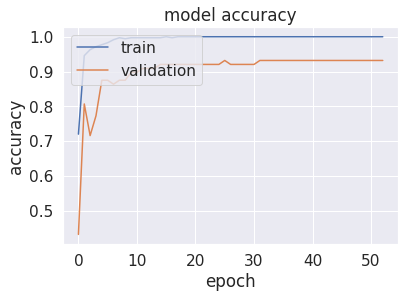

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show() 

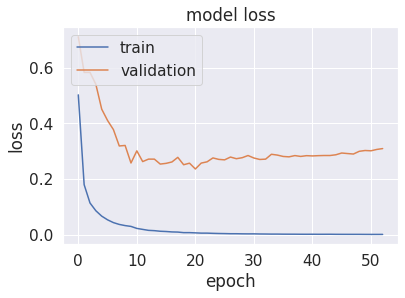

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 256, 256, 8)       224       
_________________________________________________________________
batch_normalization_11 (Batc (None, 256, 256, 8)       32        
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 256, 256, 8)       0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 128, 128, 16)      1168      
_________________________________________________________________
batch_normalization_12 (Batc (None, 128, 128, 16)      64        
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 128, 128, 16)     

In [ ]:
    model = Sequential()
    model.add(layers.Conv2D(filters=8,kernel_size=(3,3),input_shape=(256,256,3),strides=1,padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
    
    model.add(layers.MaxPooling2D(pool_size=(2,2),strides=2))
    
    model.add(layers.Conv2D(filters=16,kernel_size=(3,3),strides=1,padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Conv2D(filters=16,kernel_size=(1,1),strides=1,padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Conv2D(filters=16,kernel_size=(3,3),strides=1,padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
 
    model.add(layers.MaxPooling2D(pool_size=(2,2),strides=2))
    
    model.add(layers.Conv2D(filters=32,kernel_size=(3,3),strides=1,padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
    
    model.add(layers.Conv2D(filters=2,kernel_size=(3,3),strides=1,padding='same'))
    model.add(layers.Flatten())

    #model.add(layers.Dense(64, activation='relu')) 
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    model.load_weights('ldn3_23jun02_clahe.h5')

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
_, test_acc = model.evaluate(x_test, y_test, verbose=0)

In [ ]:
print("test accuracy: ",test_acc,)
print("test loss    : ",_)

test accuracy:  0.9666666388511658
test loss    :  0.16337584120531876


In [ ]:
y_pred=model.predict(x_test)

In [ ]:
y_pred.shape

(60, 1)

In [ ]:
#sample_labels=enc.inverse_transform(y_pred)

In [ ]:
label = []
for i in y_pred:
  if i>0.5:
    label.append(1)
  else :
    label.append(0)
print(len(label))
label = np.asarray(label)
label=label.reshape(-1,1)

60


In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:

test_acc=accuracy_score(y_test, label)

In [ ]:
test_acc

0.9666666666666667

In [ ]:
label = []
for i in y_pred:
  if i>0.5:
    label.append(1)
  else :
    label.append(0)
print(len(label))
label = np.asarray(label)
label=label.reshape(-1,1)

60


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,label)

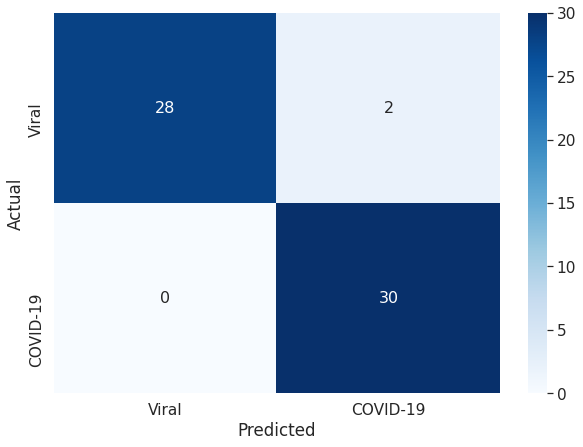

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,label)
import seaborn as sns
df_cm = pd.DataFrame(cm, columns=['Viral','COVID-19'], index = ['Viral','COVID-19'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16},fmt='d')

In [ ]:
def confusion_metrics (conf_matrix):
# save confusion matrix and slice into four pieces
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    print('True Positives:', TP)
    print('True Negatives:', TN)
    print('False Positives:', FP)
    print('False Negatives:', FN)
    
    # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    
    # calculate mis-classification
    conf_misclassification = 1- conf_accuracy
    
    # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
    # calculate the specificity
    conf_specificity = (TN / float(TN + FP))
    
    # calculate precision
    conf_precision = (TN / float(TN + FP))
    # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
    print('-'*50)
    print(f'Accuracy: {round(conf_accuracy,2)}') 
    print(f'Mis-Classification: {round(conf_misclassification,2)}') 
    print(f'Sensitivity: {round(conf_sensitivity,2)}') 
    print(f'Specificity: {round(conf_specificity,2)}') 
    print(f'Precision: {round(conf_precision,2)}')
    print(f'f_1 Score: {round(conf_f1,2)}')

In [ ]:
confusion_metrics(cm)

True Positives: 30
True Negatives: 28
False Positives: 2
False Negatives: 0
--------------------------------------------------
Accuracy: 0.97
Mis-Classification: 0.03
Sensitivity: 1.0
Specificity: 0.93
Precision: 0.93
f_1 Score: 0.97
